In [1]:
""" from local space
from google.colab import files
uploaded = files.upload()
"""
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -qU catboost eif shap category_encoders optuna
from catboost import CatBoostRegressor, Pool, CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm
import eif
import category_encoders as ce
import shap
import optuna
from optuna.samplers import TPESampler

In [3]:
import sys
from IPython.display import clear_output
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, IsolationForest, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, roc_curve, auc, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from scipy.stats import mannwhitneyu, shapiro, probplot
from scipy.stats import chi2_contingency
from scipy import stats
import statsmodels.stats.power as power
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import clone
from itertools import combinations
from xgboost import XGBClassifier
import xgboost
from lightgbm import LGBMClassifier
import lightgbm

In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

def cross_validation(clf, X, y, scoring='f1'):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def plot_cm_val(y_true, y_pred, X, y, estimator, scoring='f1'):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    conf_df = pd.DataFrame(cm, index=[0,1], columns=[0,1])
    scores = np.array(cross_validation(estimator, X, y, scoring=scoring))
    print('\n')
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    sns.heatmap(conf_df, cmap="Oranges", annot=True, annot_kws={"size": 16}, fmt='d')
    plt.title('Confusion matrix for test')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.subplot(122)
    plt.plot(scores, c='g', linestyle=':', label='Cross Validation Scores', marker='*')
    plt.fill_between(np.arange(scores.shape[0]), scores.mean() - scores.std(), scores.mean() + scores.std(), alpha=0.3)
    plt.axhline(0.65, c='r', linestyle='--', label='min f1_score')
    plt.axhline(scores.mean(), c='b', linestyle='-.', label='score mean')
    plt.legend(loc='best')
    plt.ylim([0.6, max(scores) + 0.1])
    plt.xticks(np.arange(scores.shape[0]))
    plt.grid()
    plt.show()

def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
    print(f'Train logloss: {log_loss(y_train, y_train_pred):.3f}, Test logloss: {log_loss(y_test, y_test_pred):.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote

def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def roc_plot(estimator, y_true, data):
    probs = estimator.predict_proba(data)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_ROC(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label=True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)

    print('Train Accuracy: %s ' %acc_train)
    print('Train AUC: %s ' %auc_train)
    print('Train Confusion Matrix:')
    print(cm_train)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)

    print('Test Accuracy: %s ' %acc_test)
    print('Test AUC: %s ' %auc_test)
    print('Test Confusion Matrix:')
    print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(122)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    plt.savefig('ROC', dpi = 500)
    plt.show()

    return best_threshold

In [5]:
np.random.seed(1)
data_root = r'/content/drive/My Drive/data/cardio/cardio.csv'
TARGET_NAME = 'cardio'

In [6]:
df = pd.read_csv(data_root, sep=';')
df.set_index('id', drop=True, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [ ]:
df.sample(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
9510,16099,1,153,93.0,140,90,1,1,0,0,1,1
70773,14437,1,157,89.0,120,80,1,1,0,0,1,1
72486,19839,1,165,66.0,150,90,1,1,0,0,1,1
31877,18050,2,176,88.0,160,100,2,2,1,1,1,1
77086,16819,2,165,78.0,140,90,1,1,0,0,0,1


In [ ]:
df.duplicated().astype(int).sum()

24

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
cat_df = df[['gender', 'cholesterol', 'gluc', 'smoke', 'alco']]
for col in cat_df.columns: cat_df[col] = cat_df[col].astype("category")
cat_df.describe(include="category")

,gender,cholesterol,gluc,smoke,alco
count,69976,69976,69976,69976,69976
unique,2,3,3,2,2
top,1,1,1,0,0
freq,45509,52361,59455,63807,66212


In [ ]:
for col in cat_df.columns: print(cat_df[col].value_counts(), '\n', '='*30)

1    45509
2    24467
Name: gender, dtype: int64 
1    52361
2     9549
3     8066
Name: cholesterol, dtype: int64 
1    59455
3     5331
2     5190
Name: gluc, dtype: int64 
0    63807
1     6169
Name: smoke, dtype: int64 
0    66212
1     3764
Name: alco, dtype: int64 


In [ ]:
# classes are balanced, so we do not need over/under/smote sampling or setting class-weights to strike the model
df[TARGET_NAME].value_counts(normalize=True)

0    0.500229
1    0.499771
Name: cardio, dtype: float64

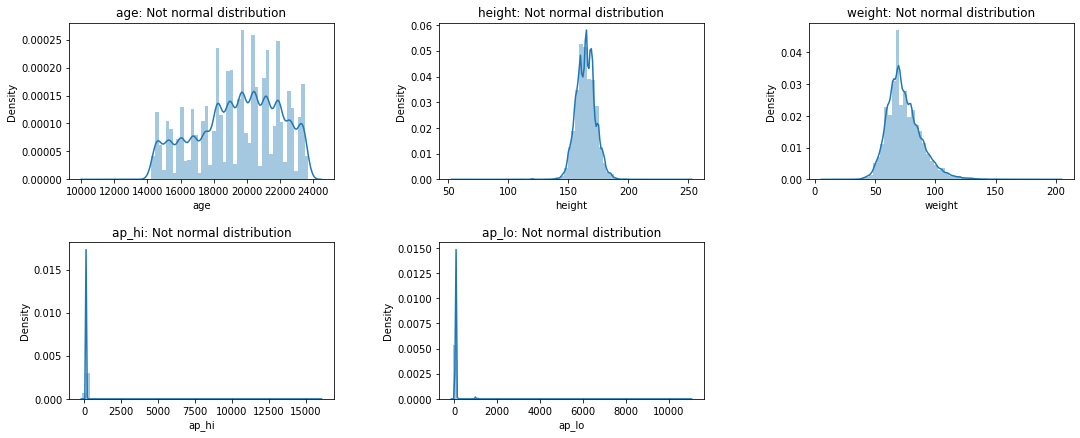

In [ ]:
plt.figure(figsize=(18, 15))
for idx, col in enumerate(['age', 'height', 'weight', 'ap_hi', 'ap_lo']):
    plt.subplot(4, 3, idx + 1)
    dist = 'Normal Distribution' if shapiro(df[col].sample(1000))[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{col}: {dist}')
    sns.distplot(df[col], bins=60)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

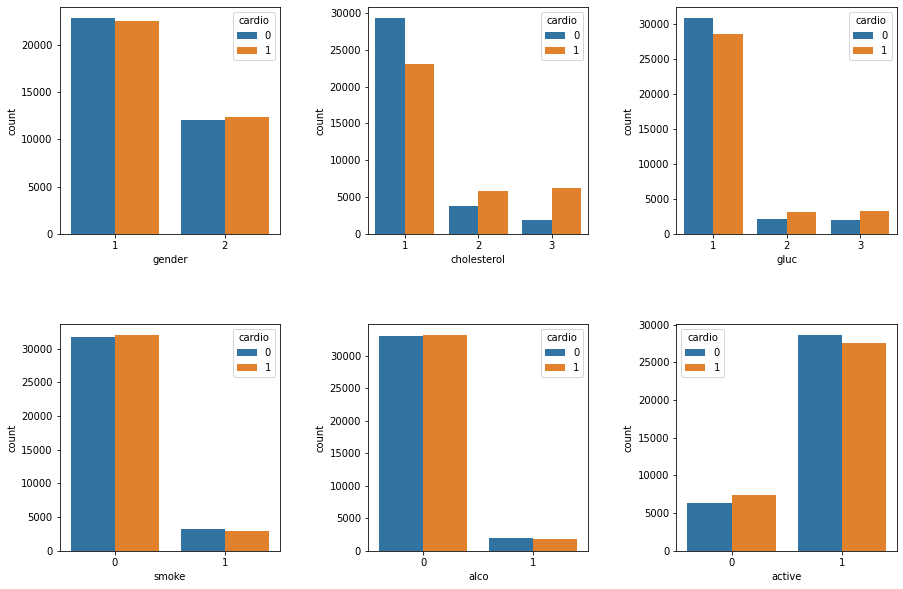

In [ ]:
cat_df = df[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', TARGET_NAME]]
plt.figure(figsize=(15, 10))
for idx, col in enumerate(cat_df.columns[:-1], 1):
    plt.subplot(2, 3, idx)
    sns.countplot(x=col, hue=TARGET_NAME, data=cat_df)  # barplot
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

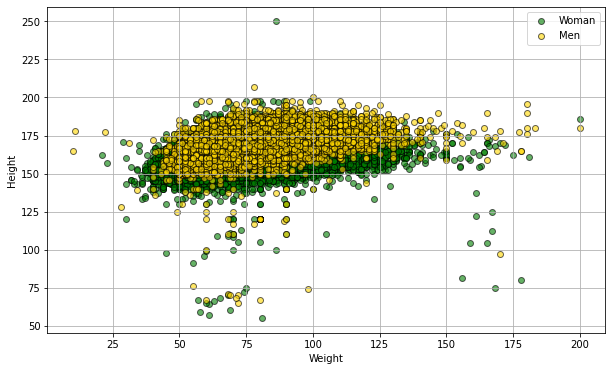

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df[df.gender == 1].weight, df[df.gender == 1].height, c='green', alpha=0.6, label='Woman', edgecolors='black')
plt.scatter(df[df.gender == 2].weight, df[df.gender == 2].height, c='gold', alpha=0.6, label='Men', edgecolors='black')
plt.ylabel('Height')
plt.xlabel('Weight')
plt.legend()
plt.grid()
plt.show()

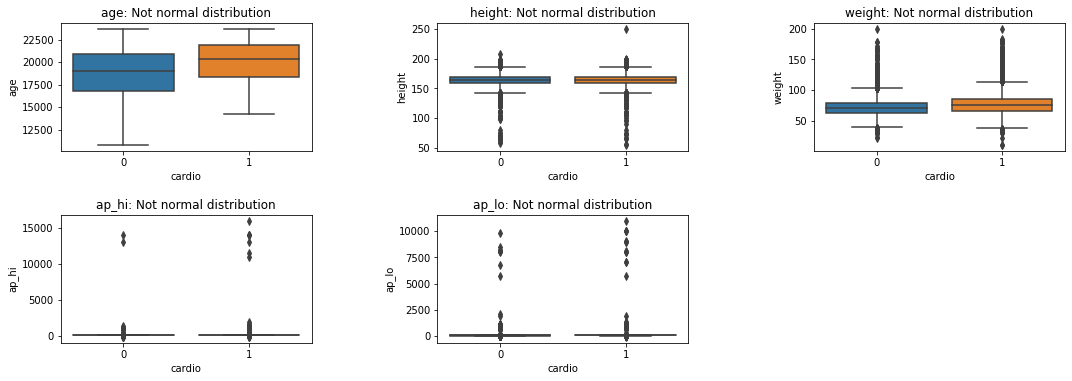

In [ ]:
plt.figure(figsize=(18,20))
for i, column in enumerate(df.drop([*cat_df.columns.to_list(), TARGET_NAME], axis=1).columns, 1):
    plt.subplot(6,3, i)
    sns.boxplot(y=df[column], x=df[TARGET_NAME], data=df)
    dist = 'Normal Distribution' if shapiro(df[column].sample(3000).dropna())[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{column}: {dist}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [ ]:
# Z-score
vocab_out = {}
for column in df.drop([*cat_df.columns.to_list(), TARGET_NAME], axis=1).columns:
    mean_col = df[column].mean()
    std_col = df[column].std()
    outliers = [x for x in df[column] if (x - mean_col) / std_col > 3 or x < 0]
    vocab_out[column] = df[df[column].isin(outliers)].index.to_list()
out_set = set()
for column, indices in vocab_out.items():
    vocab_out[column] = df[column][list(vocab_out[column])].index
for value in vocab_out.values():
    for x in value:
        out_set.add(x)
indices = list(out_set)

In [ ]:
df.loc[indices, :] # ap_lo /= 10 or drop

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
61440,23314,1,158,63.0,160,1000,3,3,0,0,1,1
75777,22361,2,168,75.0,160,1000,3,3,1,0,1,1
65538,16592,2,168,98.0,190,1100,3,1,0,1,1,1
57347,23363,2,176,97.0,150,1000,1,1,0,0,1,1
26630,18273,1,168,168.0,110,70,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
43002,17442,2,157,77.0,150,1000,1,1,0,0,1,1
26619,14680,2,178,152.0,140,90,2,2,0,0,1,0
36860,16136,2,176,80.0,160,1000,1,1,0,0,1,1


In [ ]:
df.drop(index=indices)

In [ ]:
df.drop(index=indices)[df.ap_lo > df.ap_hi]  # after dropping: swap or drop

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
681,19099,1,156,65.0,120,150,2,1,0,0,1,0
815,21281,1,168,78.0,14,90,2,1,0,0,1,1
913,20457,2,169,68.0,70,110,1,1,0,0,1,0
1294,21867,2,175,70.0,14,90,3,1,0,0,1,1
1360,18225,1,172,65.0,11,80,1,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
98213,18755,1,158,74.0,14,90,1,1,0,0,1,1
98568,19107,1,154,77.0,14,90,1,1,0,0,1,0
98743,15442,2,176,65.0,12,80,1,1,0,0,1,0


In [ ]:
df.drop(index=indices)[(df.height < 80) | (df.height > 220)]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
309,21800,2,76,55.0,120,80,1,1,0,0,1,0
10843,14661,2,70,72.0,120,8,1,1,0,0,1,0
18928,22456,2,71,68.0,120,80,3,1,0,0,1,0
20459,22005,1,67,57.0,120,90,1,1,0,0,1,1
21686,15812,1,70,68.0,120,80,1,1,0,0,0,0
23859,19680,2,74,98.0,140,90,1,1,0,0,1,1
32207,14538,1,68,65.0,100,60,1,1,0,0,0,0
32456,23386,1,55,81.0,130,90,1,1,0,0,1,1
39462,20978,1,64,61.0,130,70,1,1,0,0,1,0


In [ ]:
df.drop(index=indices)[(df.weight < 30) | (df.weight > 180)]  # drop

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
38312,23284,1,157,23.0,110,80,1,1,0,0,1,0
42156,20408,2,177,22.0,120,80,1,1,1,1,1,0
48318,21582,2,178,11.0,130,90,1,1,0,0,1,1
48976,14664,2,128,28.0,120,80,1,1,0,0,1,0
85931,21855,1,162,21.0,120,80,2,1,0,0,1,1
86650,18875,1,171,29.0,110,70,2,1,0,0,1,1


In [ ]:
outliers_data = df.drop([*cat_df.columns.to_list(), TARGET_NAME], axis=1)
iso = IsolationForest(n_estimators=150, contamination=0.01, random_state=1)
outliers = iso.fit_predict(outliers_data)

In [ ]:
df[(outliers != -1) & (df.weight < 30)]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
38312,23284,1,157,23.0,110,80,1,1,0,0,1,0
42156,20408,2,177,22.0,120,80,1,1,1,1,1,0
48318,21582,2,178,11.0,130,90,1,1,0,0,1,1
48976,14664,2,128,28.0,120,80,1,1,0,0,1,0
82567,18804,2,165,10.0,180,1100,2,2,0,0,1,1
85931,21855,1,162,21.0,120,80,2,1,0,0,1,1
86650,18875,1,171,29.0,110,70,2,1,0,0,1,1


In [ ]:
df.shape

(69976, 12)

In [ ]:
# Dealing with outliers: dropping all outliers
df = df[df.ap_hi.between(50,250)]
df = df[df.ap_lo.between(20,170)]
df = df[df.ap_hi > df.ap_lo]
df = df[df.height.between(80, 200)]
df = df[df.weight.between(30,190)]
df.shape

(68636, 12)

In [ ]:
# Dealing with outliers: replacing and dropping
df.loc[df.ap_hi > 5000, 'ap_hi'] /= 100
df.loc[df.ap_hi > 600, 'ap_hi'] /= 10
df.loc[df.ap_hi < 20, 'ap_hi'] *= 10
df.loc[df.ap_lo < 20, 'ap_lo'] *= 10
df.loc[df.ap_lo > 1000, 'ap_lo'] /= 100
df.loc[df.ap_lo > 300, 'ap_lo'] /= 10
df.ap_hi, df.ap_lo = np.where(df.ap_hi < df.ap_lo, (df.ap_lo, df.ap_hi), (df.ap_hi, df.ap_lo))
df.loc[df.height < 80, 'height'] += 100
df = df[df.weight.between(30,190)]
df.shape

(69967, 12)

In [ ]:
# converting age
df.age = df.age/365.25
# converting dtypes to floats
df.height = df.height.astype(np.float32)
df.ap_hi = df.ap_hi.astype(np.float32)
df.ap_lo = df.ap_lo.astype(np.float32)
# reducing memory
df = reduce_memory(df)

Memory usage of dataframe is 6.02 MB
Memory usage after optimization is: 2.29 MB
Decreased by 62.0%


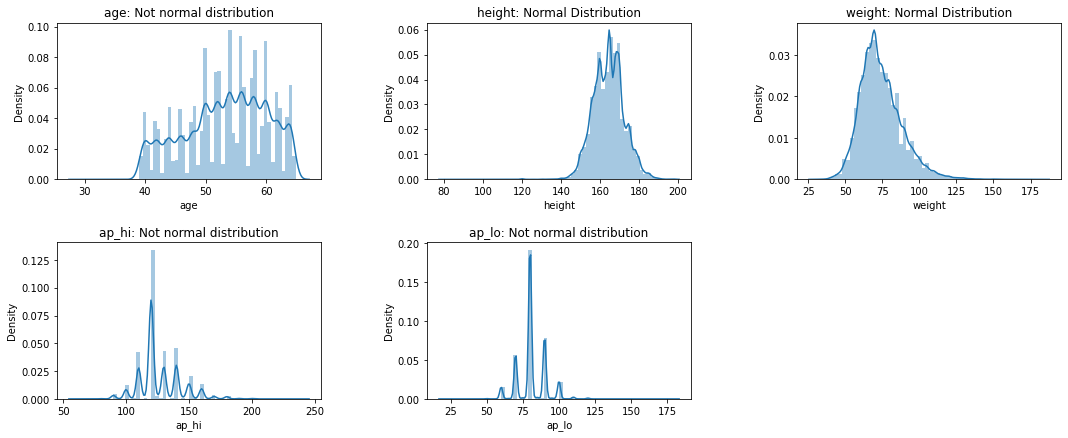

In [ ]:
# distribution after dropping all otliers that were found
plt.figure(figsize=(18, 15))
for idx, col in enumerate(['age', 'height', 'weight', 'ap_hi', 'ap_lo']):
    plt.subplot(4, 3, idx + 1)
    dist = 'Normal Distribution' if shapiro(df[col].sample(100))[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{col}: {dist}')
    sns.distplot(df[col], bins=60)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [ ]:
# base result with dropping all outliers that were found
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
base = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', 
                                                          C=1000.0, tol=1e-4, max_iter=200)) # classes are balanced
base.fit(X_train, y_train)
base_train_pred = base.predict(X_train)
base_test_pred = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]
report(y_train, base_train_pred, y_test, base_test_pred, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.707     0.785     0.744     24271
           1      0.752     0.668     0.708     23774

    accuracy                          0.727     48045
   macro avg      0.730     0.726     0.726     48045
weighted avg      0.729     0.727     0.726     48045

Test
               precision    recall  f1-score   support

           0      0.709     0.783     0.744     10402
           1      0.752     0.672     0.709     10189

    accuracy                          0.728     20591
   macro avg      0.730     0.727     0.727     20591
weighted avg      0.730     0.728     0.727     20591

Train ROC_AUC: 0.793, Test ROC_AUC: 0.788
Train logloss: 9.430, Test logloss: 9.400
Confusion Matrix 
 col_0      0     1
cardio            
0       8144  2258
1       3346  6843


In [ ]:
# base result with replacin all outliers that were assumed
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
base = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', 
                                                          C=1000.0, tol=1e-4, max_iter=200)) # classes are balanced
base.fit(X_train, y_train)
base_train_pred = base.predict(X_train)
base_test_pred = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]
report(y_train, base_train_pred, y_test, base_test_pred, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.707     0.785     0.744     24271
           1      0.752     0.668     0.708     23774

    accuracy                          0.727     48045
   macro avg      0.730     0.726     0.726     48045
weighted avg      0.729     0.727     0.726     48045

Test
               precision    recall  f1-score   support

           0      0.709     0.783     0.744     10402
           1      0.752     0.672     0.709     10189

    accuracy                          0.728     20591
   macro avg      0.730     0.727     0.727     20591
weighted avg      0.730     0.728     0.727     20591

Train ROC_AUC: 0.793, Test ROC_AUC: 0.788
Train logloss: 9.430, Test logloss: 9.400
Confusion Matrix 
 col_0      0     1
cardio            
0       8144  2258
1       3346  6843


Меры правильности перекрекстной оценки: [0.71572492 0.71256684 0.71088129 0.70773322 0.71235307 0.70072333
 0.70645447 0.70150258 0.69968624 0.70441373]
Точность перекретсной оценки: 0.707 +/- 0.005




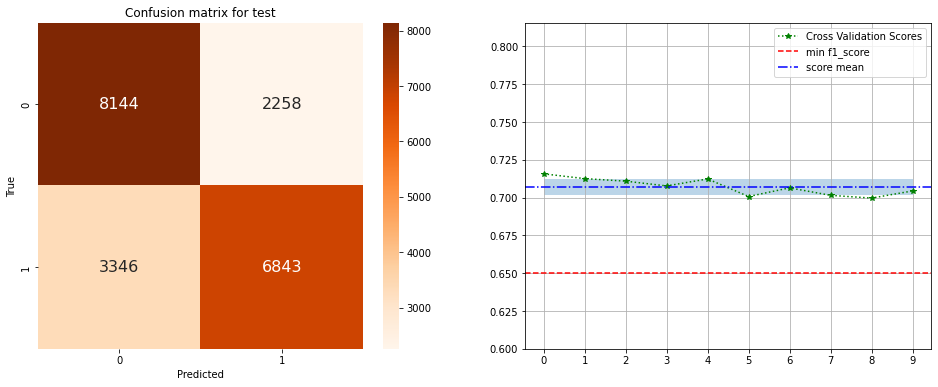

In [ ]:
plot_cm_val(y_test, base_test_pred, X_train, y_train, base)

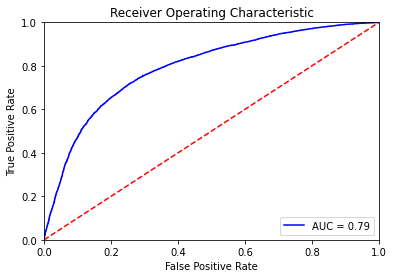

In [ ]:
roc_plot(base, y_test, X_test)

In [ ]:
# when replacing all outliers the recall is worse, but other metrics are ok
# conclusion: seems like we found most part of imputation (human) errors

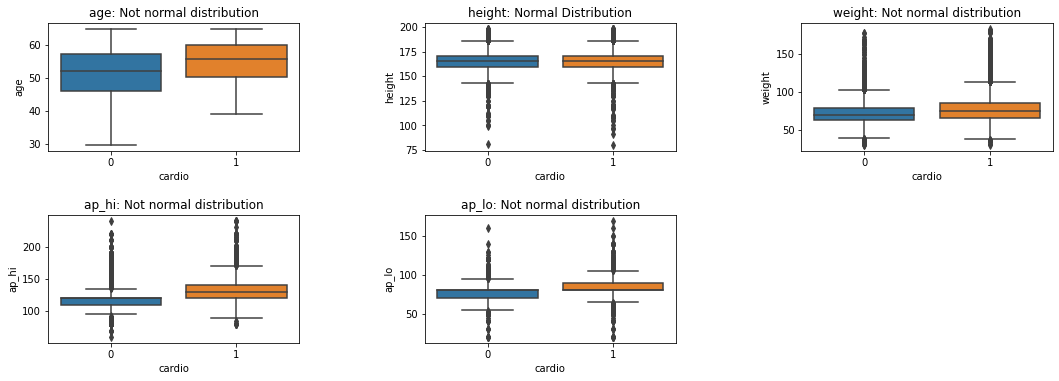

In [ ]:
plt.figure(figsize=(18,20))
for i, column in enumerate(df.drop([*cat_df.columns.to_list(), TARGET_NAME], axis=1).columns, 1):
    plt.subplot(6,3, i)
    sns.boxplot(y=df[column], x=df[TARGET_NAME], data=df)
    dist = 'Normal Distribution' if shapiro(df[column].sample(100).dropna())[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{column}: {dist}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

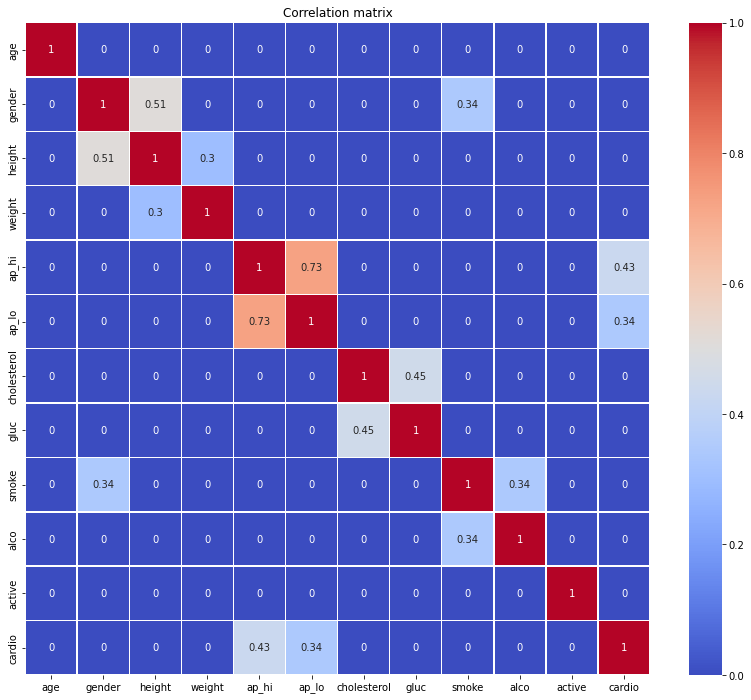

In [ ]:
plt.figure(figsize = (14,12))
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()
# as expected we see high correlation (>0.66) between ap_hi and ap_lo. 
# In regression task we shoud drop ap_lo, as less correlated to target variable, but we will 
# try to manage some combination of ap_hi and ap_lo or let Selector class to solve this issue

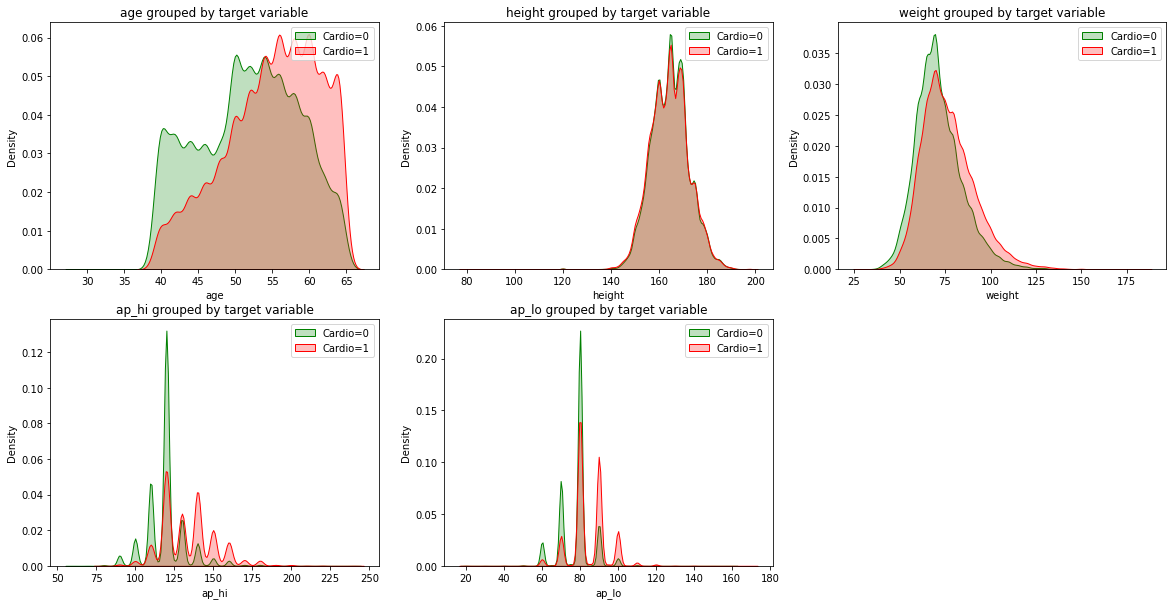

In [ ]:
plt.figure(figsize=(20, 10))
for idx, col in enumerate(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], 1):
    plt.subplot(2, 3, idx)
    feature_with_target_s = df[[col, TARGET_NAME]]
    feature_s = feature_with_target_s[col]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]

    sns.kdeplot(feature_target_0, shade=True, label='Cardio=0', color='g')
    sns.kdeplot(feature_target_1, shade=True, label='Cardio=1', color='r')
    plt.xlabel(col)
    plt.title(f'{col} grouped by target variable')
    plt.legend(loc='best')
plt.show()

In [ ]:
for idx, column in enumerate(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], 1):
    feature_with_target_s = df[[column, TARGET_NAME]] 
    feature_s = feature_with_target_s[column]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]
    mw = mannwhitneyu(feature_target_0, feature_target_1)
    imp = np.where(mw.pvalue < 0.05, 'usefull', 'useless') # statisticaly significant values
    if imp == 'usefull' and shapiro(feature_s.sample(500))[1] < 0.05:  
        print(f'{idx}) {column}, p-value: {mw.pvalue}, feature is {imp}')
    else:
        print('='*45)

1) age, p-value: 0.0, feature is usefull
2) height, p-value: 0.0005683125733099449, feature is usefull
3) weight, p-value: 0.0, feature is usefull
4) ap_hi, p-value: 0.0, feature is usefull
5) ap_lo, p-value: 0.0, feature is usefull


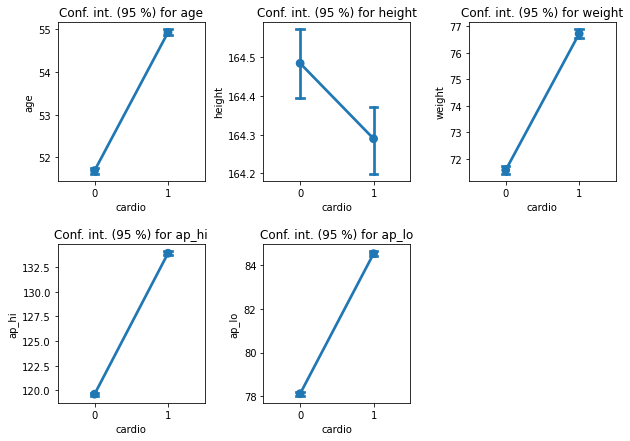

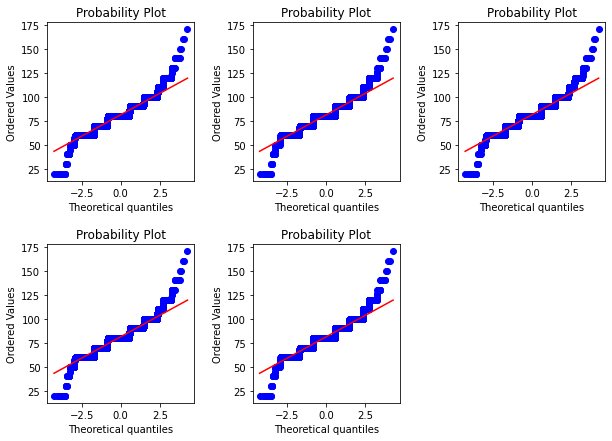

In [ ]:
plt.figure(figsize=(10, 7))
for idx, col in enumerate(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], 1):
    plt.subplot(2, 3, idx)
    to_plot = df[[col, TARGET_NAME]]
    sns.pointplot(x=TARGET_NAME, y=col, data=to_plot, capsize=.1)
    plt.title(f'Conf. int. (95 %) for {col}')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
plt.figure(figsize=(10, 7))
for idx, col in enumerate(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], 1):
    plt.subplot(2, 3, idx)
    plt.title(f'{col}')
    feature_with_target_s = df[[column, TARGET_NAME]] 
    feature_s = feature_with_target_s[column]
    probplot(feature_s, dist='norm', plot=plt)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# conclusion: all that variables are useful, height is nearly useful as we can see from dist plot and CI
# CI are very close and distributions are nearly the same

In [ ]:
# binary encoding...
df.gender = df.gender.apply(lambda x: x-1)

In [ ]:
# make categorical columns, SKIP this step if using CatBoost encoding or catboost model
for column in ['cholesterol', 'gluc']:
    df[column] = df[column].astype("category")

In [ ]:
# SKIP if using catboost encoding
#df = pd.get_dummies(df, drop_first=False, columns=df.select_dtypes('category').columns.to_list())
#df.head(3)

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,50.357288,1,168.0,62.0,110.0,80.0,0,0,1,0,1,0,0,1,0,0
1,55.381245,0,156.0,85.0,140.0,90.0,0,0,1,1,0,0,1,1,0,0
2,51.627651,0,165.0,64.0,130.0,70.0,0,0,0,1,0,0,1,1,0,0


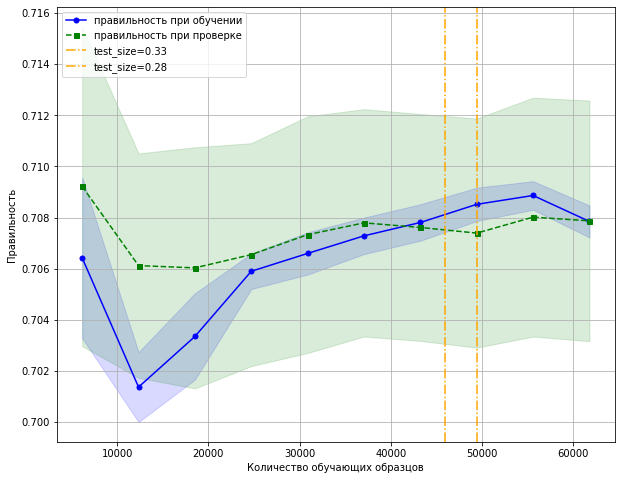

In [ ]:
# look up for better split
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
estimator = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200))
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='f1', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.67, color='orange', linestyle='-.', label='test_size=0.33')
plt.axvline(X.shape[0]*0.72, color='orange', linestyle='-.', label='test_size=0.28')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# we may take test_size=0.3

In [ ]:
# Feature engeneering

In [ ]:
df['ap_ratio'] = df.ap_hi / df.ap_lo # to measure the distance between high and low, big distance is health harmful 
# external: mortality in usa from heart diseases in 2016, 0 - female, 1 - male
df['mortality'] = 0
df.loc[((df.gender == 0) & (df.age < 1)), 'mortality'] = 7.6
df.loc[((df.gender == 0) & (df.age.between(1,4))), 'mortality'] = 0.7
df.loc[((df.gender == 0) & (df.age.between(5,14))), 'mortality'] = 0.4
df.loc[((df.gender == 0) & (df.age.between(15,24))), 'mortality'] = 1.5
df.loc[((df.gender == 0) & (df.age.between(25,34))), 'mortality'] = 5.2
df.loc[((df.gender == 0) & (df.age.between(35,44))), 'mortality'] = 16.4
df.loc[((df.gender == 0) & (df.age.between(45,54))), 'mortality'] = 47.4
df.loc[((df.gender == 0) & (df.age.between(55,64))), 'mortality'] = 113.5
df.loc[((df.gender == 0) & (df.age.between(65,74))), 'mortality'] = 266
df.loc[((df.gender == 0) & (df.age.between(75,84))), 'mortality'] = 826.4
df.loc[((df.gender == 0) & (df.age > 84)), 'mortality'] = 3589.7
df.loc[((df.gender == 1) & (df.age < 1)), 'mortality'] = 7.2
df.loc[((df.gender == 1) & (df.age.between(1,4))), 'mortality'] = 0.8
df.loc[((df.gender == 1) & (df.age.between(5,14))), 'mortality'] = 0.5
df.loc[((df.gender == 1) & (df.age.between(15,24))), 'mortality'] = 2.8
df.loc[((df.gender == 1) & (df.age.between(25,34))), 'mortality'] = 10.2
df.loc[((df.gender == 1) & (df.age.between(35,44))), 'mortality'] = 35.5
df.loc[((df.gender == 1) & (df.age.between(45,54))), 'mortality'] = 112.5
df.loc[((df.gender == 1) & (df.age.between(55,64))), 'mortality'] = 271.3
df.loc[((df.gender == 1) & (df.age.between(65,74))), 'mortality'] = 536.4
df.loc[((df.gender == 1) & (df.age.between(75,84))), 'mortality'] = 1312
df.loc[((df.gender == 1) & (df.age > 84)), 'mortality'] = 4403.5

In [ ]:
# encode with catboost encoder
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)

gr_df = pd.concat([X_train, y_train], axis=1).groupby(by=['gender', 'smoke', 'alco', 'active']).agg({TARGET_NAME: 'count'}).reset_index()
gr_df.rename(columns={'cardio': 'target_cnt'}, inplace=True)
X_train = X_train.merge(gr_df, on=['gender', 'smoke', 'alco', 'active'], how='left')
X_test = X_test.merge(gr_df, on=['gender', 'smoke', 'alco', 'active'], how='left')

encoder = ce.CatBoostEncoder(cols=['cholesterol', 'gluc'], random_state=1)
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [ ]:
# Feature selector: try on DecisionTreeClassifier

In [7]:
class ChooseBestSubset:
    def __init__(self, estimator, k_features, scoring='f1_score', test_size=0.2, random_state=1):
        self.scoring = str(scoring)
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        if (self.scoring == 'f1_score') or (self.scoring == 'accuracy_score'):
            self.scoring = eval(self.scoring)
        else:
            raise ValueError(f'Метрика должна быть "f1_score" или "accuracy_score", дана: {self.scoring}')
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, stratify=y, shuffle=True,
                                                           random_state=self.random_state)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_) # сначала для полного набора
        self.scores_ = [score]
        while dim > self.k_features: # цикл до тех пор, пока не будет наименее короткий заданный набор
            scores, subsets = [], []
            sys.stderr.write(f'Анализ наборов признаков {dim}/{X_train.shape[1]}, осталось {dim - self.k_features}:')
            for p in tqdm(combinations(self.indices_, r=dim-1), total=dim): # проверяем различные комбинации признаков 
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score) # записываем score текущего набора
                subsets.append(p) # записываем значения индексов текущего набора
            clear_output(wait=True)
            best = np.argmax(scores) # находим лучший набор
            self.indices_ = subsets[best] # сохраняем значения индексов лучшего набора из текущей итерации while
            self.subsets_.append(self.indices_) # сохраняем лучший набор из текущей итерации while
            dim -= 1
            self.scores_.append(scores[best]) # сохраняем лучшее значение метрики на текущей итерации
        self.k_score_ = self.scores_[-1] # scores для последнего набора = k_features
        return self
    def _calc_score(self, X_train, y_train, X_test, y_test, indices): # вычисляем метрику набора
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [ ]:
X_train.head() # for catboost do not use encoding

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,ap_ratio,mortality,target_cnt
0,57.774128,0,158.0,89.0,110.0,70.0,0.764549,0.475303,0,0,1,1.571429,113.5,24086
1,61.774128,0,169.0,75.0,140.0,80.0,0.435052,0.588809,0,0,0,1.750000,113.5,5965
2,41.700207,0,161.0,106.0,150.0,90.0,0.435052,0.475303,0,0,1,1.666667,16.4,24086
3,46.091717,0,162.0,74.0,130.0,95.0,0.599707,0.475303,0,0,1,1.368421,47.4,24086
4,55.791924,0,165.0,65.0,130.0,80.0,0.435052,0.475303,0,0,0,1.625000,113.5,5965


In [ ]:
lr = LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200, class_weight='balanced')
selector = ChooseBestSubset(lr, k_features=9)
selector.fit(X_train, y_train)

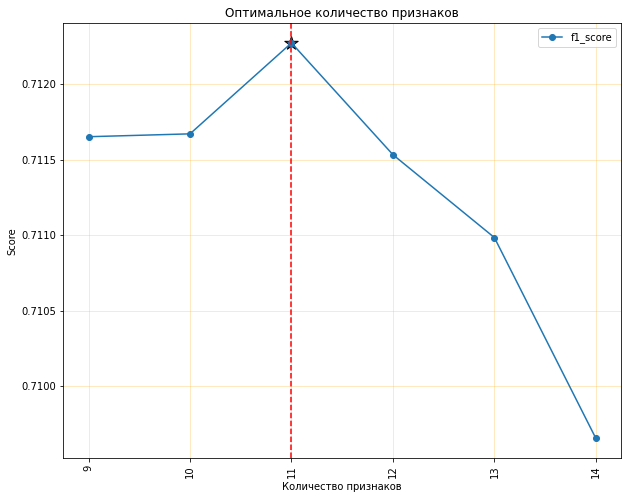

In [ ]:
k_feat = [len(k) for k in selector.subsets_] # вычисляем длины наборов
plt.figure(figsize=(10, 8))
plt.plot(k_feat, selector.scores_, marker='o', label='f1_score')
plt.scatter(k_feat[np.argmax(np.array(selector.scores_))], max(selector.scores_), marker='*', color='red', 
              ec='black', s=200)
plt.axvline(k_feat[np.argmax(np.array(selector.scores_))], color='red', linestyle='--')
plt.title('Оптимальное количество признаков')
plt.ylabel('Score')
plt.xlabel('Количество признаков')
plt.xticks(k_feat, rotation=90)
plt.legend(loc='best')
plt.grid(color='orange', alpha=0.3)
plt.show()

In [ ]:
indices = selector.subsets_[np.argmax(np.array(selector.scores_))]
X_train = X_train.values[:, indices]
X_test = X_test.values[:, indices]

In [ ]:
indices

(0, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13)

In [ ]:
# Model selection

In [ ]:
tree = DecisionTreeClassifier(max_depth=4, random_state=1)
tree.fit(X_train, y_train)
base_train_pred = tree.predict(X_train)
base_test_pred = tree.predict(X_test)
report(y_train, base_train_pred, y_test, base_test_pred)

Train
               precision    recall  f1-score   support

           0      0.706     0.780     0.741     24271
           1      0.749     0.668     0.706     23774

    accuracy                          0.725     48045
   macro avg      0.727     0.724     0.724     48045
weighted avg      0.727     0.725     0.724     48045

Test
               precision    recall  f1-score   support

           0      0.708     0.776     0.740     10402
           1      0.747     0.673     0.708     10189

    accuracy                          0.725     20591
   macro avg      0.727     0.725     0.724     20591
weighted avg      0.727     0.725     0.724     20591

Train ROC_AUC: 0.724, Test ROC_AUC: 0.725
Train logloss: 9.505, Test logloss: 9.492
Confusion Matrix 
 col_0      0     1
cardio            
0       8074  2328
1       3331  6858


In [ ]:
# feature importancies with RandomForest

In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=4, random_state=1)
rf.fit(X_train, y_train)
base_train_pred = rf.predict(X_train)
base_test_pred = rf.predict(X_test)

1) ap_hi	0.41944527273277554
2) ap_lo	0.27566519042950166
3) ap_ratio	0.09715834485940474
4) age	0.08090293382309893
5) cholesterol	0.06909603289271946
6) mortality	0.03972359731850788
7) weight	0.016332976120542464
8) target_cnt	0.0006662218612999242
9) height	0.0005997645875817584
10) smoke	0.0002746818666943765
11) alco	0.00013498350787327388


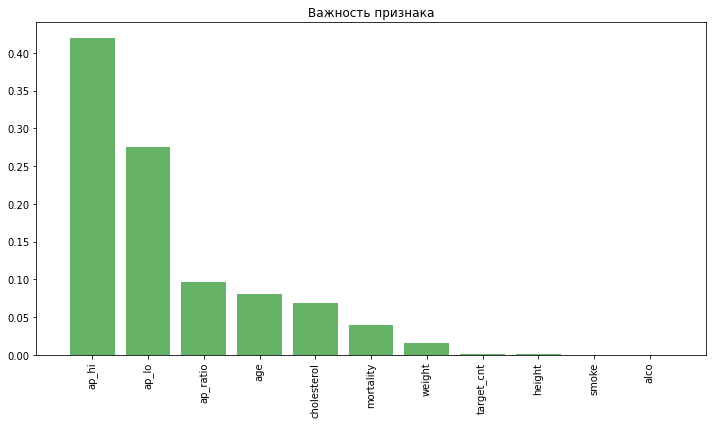

In [ ]:
cols = X.columns.to_list() + ['target_cnt'] 
feat_labels = np.array([cols[i] for i in indices])
importances = rf.feature_importances_
indices_ = np.argsort(importances)[::-1]
for x in range(X_train.shape[1]):
    print(f'{x+1}) {feat_labels[indices_[x]]}\t{importances[indices_[x]]}')
plt.figure(figsize=(10, 6))
plt.title('Важность признака')
plt.bar(range(X_train.shape[1]), importances[indices_], align='center', alpha=0.6, color='green')
plt.xticks(np.arange(X_train.shape[1]), feat_labels[indices_], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()
# features that minimize the loss mostly during node split

In [16]:
def pipeline(root=data_root, cat=False, apply_selector=True, num_features=8, clean_method='drop'):
    print('Reading dataframe')
    df = pd.read_csv(root, sep=';')
    df.set_index('id', drop=True, inplace=True)
    print('Dropping duplicates')
    df.drop_duplicates(inplace=True)
    print('Dealing with outliers, converting features')
    if clean_method == 'drop':
        df = df[df.ap_hi.between(50,250)]  # 50 220
        df = df[df.ap_lo.between(30,170)]  # 40 150
        df = df[df.ap_hi > df.ap_lo]
        df = df[df.height.between(80, 200)]  # 120 200
        df = df[df.weight.between(30,190)]  # 40 170
        print(f'Samples left: {df.shape[0]}')
    elif clean_method == 'replace':
        df.loc[df.ap_hi > 5000, 'ap_hi'] /= 100
        df.loc[df.ap_hi > 600, 'ap_hi'] /= 10
        df.loc[df.ap_hi < 20, 'ap_hi'] *= 10
        df.loc[df.ap_lo < 20, 'ap_lo'] *= 10
        df.loc[df.ap_lo > 1000, 'ap_lo'] /= 100
        df.loc[df.ap_lo > 300, 'ap_lo'] /= 10
        df.ap_hi, df.ap_lo = np.where(df.ap_hi < df.ap_lo, (df.ap_lo, df.ap_hi), (df.ap_hi, df.ap_lo))
        df.loc[df.height < 80, 'height'] += 100
        df = df[df.weight.between(30,190)]
    elif clean_method == 'mark':
        df['out'] = 0
        df.loc[~(df.ap_hi.between(50,250)), 'out'] = 1
        df.loc[~(df.ap_lo.between(20,170)), 'out'] = 1
        df.loc[(df.ap_hi > df.ap_lo), 'out'] = 1
        df.loc[~(df.height.between(80, 200)), 'out'] = 1
        df.loc[~(df.weight.between(30,190)), 'out'] = 1
        df.out = df.out.astype(np.int8)
    else:
        print('using raw data')
    df.age = df.age/365.25
    df.height = df.height.astype(np.float32)
    df.ap_hi = df.ap_hi.astype(np.float32)
    df.ap_lo = df.ap_lo.astype(np.float32)
    print('Optimizing memory usage')
    df = reduce_memory(df)
    print('Feature optimizing and generating')
    df.gender = df.gender.apply(lambda x: x-1)
    df.gender = df.gender.astype(np.int8)
    df['ap_ratio'] = 0
    df.loc[df.ap_lo != 0, 'ap_ratio'] = df.ap_hi / df.ap_lo 
    df['mortality'] = 0
    df.loc[((df.gender == 0) & (df.age < 1)), 'mortality'] = 7.6
    df.loc[((df.gender == 0) & (df.age.between(1,4))), 'mortality'] = 0.7
    df.loc[((df.gender == 0) & (df.age.between(5,14))), 'mortality'] = 0.4
    df.loc[((df.gender == 0) & (df.age.between(15,24))), 'mortality'] = 1.5
    df.loc[((df.gender == 0) & (df.age.between(25,34))), 'mortality'] = 5.2
    df.loc[((df.gender == 0) & (df.age.between(35,44))), 'mortality'] = 16.4
    df.loc[((df.gender == 0) & (df.age.between(45,54))), 'mortality'] = 47.4
    df.loc[((df.gender == 0) & (df.age.between(55,64))), 'mortality'] = 113.5
    df.loc[((df.gender == 0) & (df.age.between(65,74))), 'mortality'] = 266
    df.loc[((df.gender == 0) & (df.age.between(75,84))), 'mortality'] = 826.4
    df.loc[((df.gender == 0) & (df.age > 84)), 'mortality'] = 3589.7
    df.loc[((df.gender == 1) & (df.age < 1)), 'mortality'] = 7.2
    df.loc[((df.gender == 1) & (df.age.between(1,4))), 'mortality'] = 0.8
    df.loc[((df.gender == 1) & (df.age.between(5,14))), 'mortality'] = 0.5
    df.loc[((df.gender == 1) & (df.age.between(15,24))), 'mortality'] = 2.8
    df.loc[((df.gender == 1) & (df.age.between(25,34))), 'mortality'] = 10.2
    df.loc[((df.gender == 1) & (df.age.between(35,44))), 'mortality'] = 35.5
    df.loc[((df.gender == 1) & (df.age.between(45,54))), 'mortality'] = 112.5
    df.loc[((df.gender == 1) & (df.age.between(55,64))), 'mortality'] = 271.3
    df.loc[((df.gender == 1) & (df.age.between(65,74))), 'mortality'] = 536.4
    df.loc[((df.gender == 1) & (df.age.between(75,84))), 'mortality'] = 1312
    df.loc[((df.gender == 1) & (df.age > 84)), 'mortality'] = 4403.5
    print('Getting optimal split for train/ test; feature encoding')
    X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
    X_train_ind = X_train.index
    gr_df = pd.concat([X_train, y_train], axis=1).groupby(by=['gender', 'smoke', 'alco', 'active']).agg({TARGET_NAME: 'count'}).reset_index()
    gr_df.rename(columns={'cardio': 'target_cnt'}, inplace=True)
    X_train = X_train.merge(gr_df, on=['gender', 'smoke', 'alco', 'active'], how='left')
    X_test = X_test.merge(gr_df, on=['gender', 'smoke', 'alco', 'active'], how='left')
    X_train.index = X_train_ind
    del gr_df
    if not cat:
        print('Catboost encoding')
        encoder = ce.cat_boost.CatBoostEncoder(cols=['cholesterol', 'gluc'], random_state=1)
        encoder.fit(X_train, y_train)
        X_train = encoder.transform(X_train)
        X_test = encoder.transform(X_test)
        if apply_selector:
            print('Selecting best subset')
            lr = LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200)
            selector = ChooseBestSubset(lr, k_features=num_features)
            # print(X_train.loc[~np.isfinite(X_train.values), :]) # checked zero-division
            selector.fit(X_train, y_train)
            indices = selector.subsets_[np.argmax(np.array(selector.scores_))]
            X_train = X_train.values[:, indices]
            X_test = X_test.values[:, indices]
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = pipeline(data_root)

Анализ наборов признаков 9/14, осталось 1:

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
def effect_size(factor_a, factor_b, cohen=True, desired_power=0.8, alpha=0.05):
    n1, n2 = len(factor_a), len(factor_b)
    s1, s2 = factor_a.std(ddof=1), factor_b.std(ddof=1)
    df = (s1 ** 2 / n1 + s2 ** 2 / n2) ** 2 / \
          ((s1 ** 2 / n1) ** 2 / (n1 - 1) + (s2 ** 2 / n2) ** 2 / (n2 - 1))
    if cohen:
        sigma_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        return np.abs(factor_a.mean() - factor_b.mean()) / sigma_pooled, df
    else:
        return power.tt_ind_solve_power(effect_size=None, nobs1=len(factor_a), alpha=alpha, power=desired_power,
                                        ratio=len(factor_b)/len(factor_a), alternative='two-sided'), df

def statistic_output(*columns, df=df, cat=False, target=TARGET_NAME, alpha=0.05, sample_size=0):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    if not cat:
        columns = data.drop(target, axis=1).select_dtypes(exclude=['category', np.object]).columns
        for column in columns:
            df_sampled = data[[column, target]].sample(sample_size, random_state=1)
            factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
            factor_b = df_sampled.loc[df_sampled[target] == 1][column]
            var_a, var_b = factor_a.var(), factor_b.var()   
            _, pvalue = stats.shapiro(df_sampled[column])
            if pvalue >= alpha:
                _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
                test = power.TTestIndPower()
                eff_size, deg_free = effect_size(factor_a, factor_b, cohen=False)
                pow = test.power(effect_size=eff_size, nobs1=len(factor_a), alpha=alpha, df=deg_free, 
                                 ratio=len(factor_b)/len(factor_a), alternative='two-sided')
            else:
                _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
                pow, eff_size = None, None
            if pvalue < alpha:
                result = f'with effect_size = {eff_size:.4f} and ttest power {pow*100:.2f}%' if pow is not None else ''
                print(f'Factor "{column}" has statistical influence on target (var_a: {var_a:.2f}, var_b: {var_b:.2f}). {result}')
            else:
                print(f'Factor "{column}" does not affect target.')
    else:
        for column in columns:
            print(column)
            data.reset_index(inplace=True)
            categories = data[column].unique().tolist()
            for pair in combinations(categories, r=2):
                a, b = pair
                if a != b:
                    data_ = data.loc[data[column].isin(pair), ['id', column, target]].sample(sample_size, random_state=1)
                    table = data_.pivot_table(values='id', index=column, columns=target, aggfunc='count')
                    _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
                    if pvalue >= alpha:  # yield to store results: yield (a,b,res...)
                        print(f'Categories {a} and {b} can be united.')
                    else:
                        print(f'Categories {a} and {b} have different frequencies with target.')

def correlation(df: pd.DataFrame, target=TARGET_NAME, alpha=0.05, threshold=0.66, method='pearson'):
    data = df.copy()
    data = data.drop(target, axis=1)
    columns = data.select_dtypes(exclude=['category', np.object]).columns
    for pair in combinations(columns, r=2):
        col1, col2 = pair
        if method == 'pearson':
            r, pvalue = stats.pearsonr(data[col1], data[col2])
        elif method == 'kendall':
            r, pvalue = stats.kendalltau(data[col1], data[col2])
        elif method == 'spearman':
            r, pvalue = stats.spearmanr(data[col1], data[col2])                   
        else:
            raise ValueError(f'Method should be "spearman", "kendall" or "pearson", got: {method}')
        if r >= threshold:    
            if pvalue < alpha:
                print(f'Correlation ({method}) between {col1} and {col2} is statisticaly strong: {r:.4f}.')
            else:
                print(f'Correlation ({method}) between {col1} and {col2} is high but not statisticaly meaningful.')

# anova takes *arguments and compares wether means of samples are equal or not, same as 2-sampled t-test
# but with >=2 factors. So we may input in f_oneway as many factors (df_sampled with labels) as we need to compare
# here we take two factors (samples from feature) as we have binary task
def statistic_anova_output(df=df, target=TARGET_NAME, alpha=0.05, sample_size=0, method='pearson'):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    columns = data.drop(target, axis=1).select_dtypes(exclude=['category', np.object]).columns
    for column in columns:
        df_sampled = data[[column, target]].sample(sample_size, random_state=1)
        factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
        factor_b = df_sampled.loc[df_sampled[target] == 1][column]
        _, pvalue = stats.shapiro(df_sampled[column])
        r = factor_a.corr(factor_b, method=method)
        p_var_eq = stats.bartlett(factor_a, factor_b)[1] if pvalue >= alpha else stats.levene(factor_a, factor_b)[1]
        is_oneway = True if p_var_eq >= alpha else False
        if is_oneway and pvalue >= alpha and r < 0.33:
            _, pvalue = stats.f_oneway(factor_a, factor_b)
        else:
            _, pvalue = stats.kruskal(factor_a, factor_b)
        if pvalue < alpha:
            print(f'Factor "{column}" has statistical influence on target.')
        else:
            print(f'Factor "{column}" does not affect target.')

In [ ]:
#X_train, X_test, y_train, y_test = pipeline(data_root, cat=True)
#clear_output()
#train = pd.DataFrame(np.hstack((X_train, y_train.values.reshape(-1,1))), columns=X_train.columns.to_list()+[TARGET_NAME])
#correlation(df=train, method='spearman', threshold=0.66)
#statistic_output(df=train, sample_size=500)
#statistic_output('gluc', cat=True)
statistic_anova_output(df=train, sample_size=500)

Factor "age" has statistical influence on target.
Factor "gender" does not affect target.
Factor "height" does not affect target.
Factor "weight" has statistical influence on target.
Factor "ap_hi" has statistical influence on target.
Factor "ap_lo" has statistical influence on target.
Factor "cholesterol" has statistical influence on target.
Factor "gluc" does not affect target.
Factor "smoke" does not affect target.
Factor "alco" does not affect target.
Factor "active" has statistical influence on target.
Factor "ap_ratio" has statistical influence on target.
Factor "mortality" has statistical influence on target.
Factor "target_cnt" has statistical influence on target.


In [22]:
df_ = df.sample(1000)
table = pd.crosstab(df_['cholesterol'], df_['cardio'])
table

cardio,0,1
cholesterol,,
1,420,353
2,47,80
3,21,79


In [24]:
# with statistic output we decide whether it is possible to union two taken categories
# here we determin if there are statistical dependency between two variables (categorical feature and target)
stats.chi2_contingency(table, correction=False)[1] # p-value < alpha, reject H0, so target variable and cholesterol are dependent

4.912288192185777e-11

In [ ]:
# GridSearch is far too slow

In [ ]:
# K-neighbors simole model, overfits, handy params
knn = make_pipeline(RobustScaler(), KNeighborsClassifier(n_neighbors=14, p=1, n_jobs=-1, leaf_size=30))
knn.fit(X_train, y_train)
knn_train_pred = knn.predict(X_train)
knn_test_pred = knn.predict(X_test)
report(y_train, knn_train_pred, y_test, knn_test_pred)

Train
               precision    recall  f1-score   support

           0      0.721     0.818     0.766     24271
           1      0.785     0.677     0.727     23774

    accuracy                          0.748     48045
   macro avg      0.753     0.747     0.747     48045
weighted avg      0.752     0.748     0.747     48045

Test
               precision    recall  f1-score   support

           0      0.690     0.778     0.731     10402
           1      0.739     0.643     0.688     10189

    accuracy                          0.711     20591
   macro avg      0.714     0.710     0.709     20591
weighted avg      0.714     0.711     0.710     20591

Train ROC_AUC: 0.747, Test ROC_AUC: 0.710
Train logloss: 8.699, Test logloss: 9.980
Confusion Matrix 
 col_0      0     1
cardio            
0       8089  2313
1       3637  6552


In [ ]:
# Decision Tree Classifier Model
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, max_features=None, random_state=1)
tree.fit(X_train, y_train)
tree_train_pred = tree.predict(X_train)
tree_test_pred = tree.predict(X_test)
report(y_train, tree_train_pred, y_test, tree_test_pred)

Train
               precision    recall  f1-score   support

           0      0.714     0.785     0.748     24271
           1      0.756     0.678     0.715     23774

    accuracy                          0.732     48045
   macro avg      0.735     0.732     0.731     48045
weighted avg      0.735     0.732     0.732     48045

Test
               precision    recall  f1-score   support

           0      0.713     0.777     0.743     10402
           1      0.749     0.680     0.713     10189

    accuracy                          0.729     20591
   macro avg      0.731     0.728     0.728     20591
weighted avg      0.731     0.729     0.728     20591

Train ROC_AUC: 0.732, Test ROC_AUC: 0.728
Train logloss: 9.242, Test logloss: 9.362
Confusion Matrix 
 col_0      0     1
cardio            
0       8081  2321
1       3260  6929


In [ ]:
# Logistic Regression, doesn't overfit
lr = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=300))
lr.fit(X_train, y_train)
lr_train_pred = lr.predict(X_train)
lr_test_pred = lr.predict(X_test)
report(y_train, lr_train_pred, y_test, lr_test_pred)

Train
               precision    recall  f1-score   support

           0      0.705     0.784     0.742     24267
           1      0.751     0.665     0.705     23768

    accuracy                          0.725     48035
   macro avg      0.728     0.724     0.724     48035
weighted avg      0.727     0.725     0.724     48035

Test
               precision    recall  f1-score   support

           0      0.716     0.785     0.749     10400
           1      0.757     0.683     0.718     10187

    accuracy                          0.735     20587
   macro avg      0.737     0.734     0.734     20587
weighted avg      0.737     0.735     0.734     20587

Train ROC_AUC: 0.724, Test ROC_AUC: 0.734
Train logloss: 9.506, Test logloss: 9.167
Confusion Matrix 
 col_0      0     1
cardio            
0       8168  2232
1       3232  6955


In [ ]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=1, min_samples_split=100,
                            max_features=3, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)
report(y_train, rf_train_pred, y_test, rf_test_pred)

Train
               precision    recall  f1-score   support

           0      0.708     0.797     0.750     24271
           1      0.762     0.665     0.710     23774

    accuracy                          0.732     48045
   macro avg      0.735     0.731     0.730     48045
weighted avg      0.735     0.732     0.730     48045

Test
               precision    recall  f1-score   support

           0      0.709     0.792     0.749     10402
           1      0.759     0.669     0.711     10189

    accuracy                          0.731     20591
   macro avg      0.734     0.730     0.730     20591
weighted avg      0.734     0.731     0.730     20591

Train ROC_AUC: 0.731, Test ROC_AUC: 0.730
Train logloss: 9.271, Test logloss: 9.289
Confusion Matrix 
 col_0      0     1
cardio            
0       8241  2161
1       3377  6812


In [ ]:
# Stacking Classifier
knn = make_pipeline(RobustScaler(), KNeighborsClassifier(n_neighbors=14, p=1, n_jobs=-1, leaf_size=30))
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, max_features=None, random_state=1)
lr = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1.0, tol=1e-4, 
                        max_iter=300))
rf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=1, min_samples_split=100,
                            max_features=3, random_state=1, n_jobs=-1)
estimators = [('knn', knn), ('tree', tree), ('rf', rf)]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=None, n_jobs=-1)
stack.fit(X_train, y_train)
stack_train_pred = stack.predict(X_train)
stack_test_pred = stack.predict(X_test)
report(y_train, stack_train_pred, y_test, stack_test_pred)

Train
               precision    recall  f1-score   support

           0      0.723     0.789     0.755     24271
           1      0.762     0.692     0.725     23774

    accuracy                          0.741     48045
   macro avg      0.743     0.740     0.740     48045
weighted avg      0.743     0.741     0.740     48045

Test
               precision    recall  f1-score   support

           0      0.717     0.776     0.745     10402
           1      0.750     0.687     0.717     10189

    accuracy                          0.732     20591
   macro avg      0.734     0.732     0.731     20591
weighted avg      0.733     0.732     0.731     20591

Train ROC_AUC: 0.740, Test ROC_AUC: 0.732
Train logloss: 8.954, Test logloss: 9.258
Confusion Matrix 
 col_0      0     1
cardio            
0       8068  2334
1       3185  7004


In [ ]:
knn = make_pipeline(RobustScaler(), KNeighborsClassifier(n_neighbors=14, p=1, n_jobs=-1, leaf_size=30))
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, max_features=None, random_state=1)
lr = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1.0, tol=1e-4, 
                        max_iter=300))
rf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=1, min_samples_split=100,
                            max_features=3, random_state=1, n_jobs=-1)
estimators = [('knn', knn), ('tree', tree), ('rf', rf), ('lr', lr)]
voter = VotingClassifier(estimators=estimators, voting='hard', weights=[1., 1.5, 1.2, 1.5], n_jobs=-1) # soft uses predict_proba
voter.fit(X_train, y_train)
vote_train_pred = voter.predict(X_train)
vote_test_pred = voter.predict(X_test)
report(y_train, vote_train_pred, y_test, vote_test_pred)

Train
               precision    recall  f1-score   support

           0      0.707     0.804     0.752     24267
           1      0.767     0.660     0.710     23768

    accuracy                          0.733     48035
   macro avg      0.737     0.732     0.731     48035
weighted avg      0.737     0.733     0.731     48035

Test
               precision    recall  f1-score   support

           0      0.714     0.802     0.755     10400
           1      0.769     0.672     0.717     10187

    accuracy                          0.738     20587
   macro avg      0.741     0.737     0.736     20587
weighted avg      0.741     0.738     0.736     20587

Train ROC_AUC: 0.732, Test ROC_AUC: 0.737
Train logloss: 9.230, Test logloss: 9.065
Confusion Matrix 
 col_0      0     1
cardio            
0       8339  2061
1       3342  6845


In [ ]:
# XGBClassifier
def recall_eval(y_pred, dtrain):  # custom eval metric: it is strongly important not to skip ill patient
    y_true = dtrain.get_label()
    err = 1-recall_score(y_true, np.round(y_pred))
    return 'recall_err', err

def learning_rate_decay(boosting_round, num_boost_round): # custom learning rate decay
    learning_rate_start = 0.5
    learning_rate_min = 0.01
    lr_decay = 0.95
    lr = learning_rate_start * np.power(lr_decay, boosting_round)
    return max(learning_rate_min, lr)

early_stopping_rounds = 10
callbacks = [xgboost.callback.reset_learning_rate(learning_rate_decay)]

xgbc = XGBClassifier(max_depth=5, learning_rate=0.5, n_estimators=50,
                     booster='gbtree', gamma=0.1, subsample=.5, reg_alpha=0.01, reg_lambda=0.01, 
                     scale_pos_weight=1., colsample_bytree=.6, random_state=1, n_jobs=-1,
                     objective='binary:logistic', colsample_bylevel=1.)
xgbc.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=callbacks, eval_metric=recall_eval, 
         early_stopping_rounds=5, verbose=0)
x_train_pred = xgbc.predict(X_train)
x_test_pred = xgbc.predict(X_test)
report(y_train, x_train_pred, y_test, x_test_pred)

Train
               precision    recall  f1-score   support

           0      0.719     0.784     0.750     24267
           1      0.757     0.687     0.720     23768

    accuracy                          0.736     48035
   macro avg      0.738     0.735     0.735     48035
weighted avg      0.738     0.736     0.735     48035

Test
               precision    recall  f1-score   support

           0      0.722     0.778     0.749     10400
           1      0.754     0.695     0.723     10187

    accuracy                          0.737     20587
   macro avg      0.738     0.736     0.736     20587
weighted avg      0.738     0.737     0.736     20587

Train ROC_AUC: 0.735, Test ROC_AUC: 0.736
Train logloss: 9.120, Test logloss: 9.087
Confusion Matrix 
 col_0      0     1
cardio            
0       8096  2304
1       3112  7075


Меры правильности перекрекстной оценки: [0.72710241 0.73189009 0.72918401 0.72293922 0.72502082 0.71601083
 0.71913387 0.727462   0.72996044 0.72392255]
Точность перекретсной оценки: 0.725 +/- 0.005




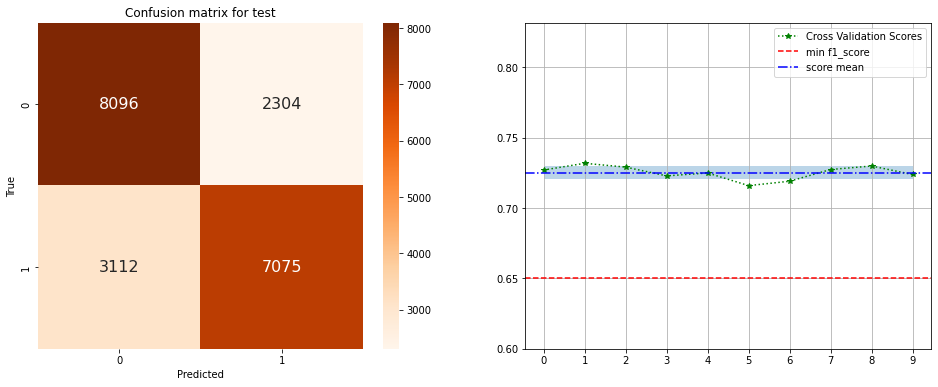

In [ ]:
plot_cm_val(y_test, x_test_pred, X_train, y_train, xgbc, scoring='accuracy')  # cv on simple accuracy, classes are balanced

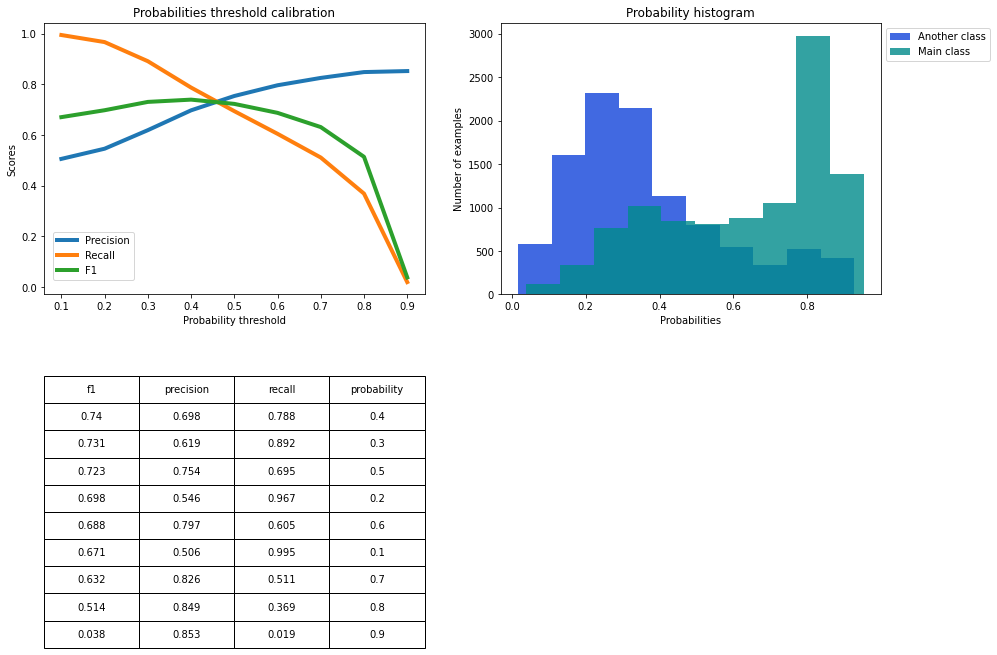

In [ ]:
show_proba_calibration_plots(xgbc.predict_proba(X_test)[:, 1], y_test)

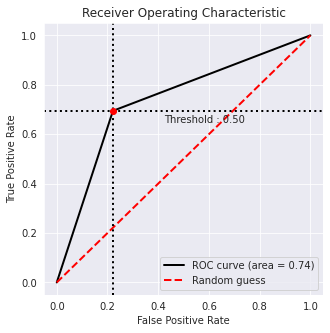

In [ ]:
!pip install plot_metric
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, x_test_pred, labels=["Cardio 0", "Cardio 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

Train Accuracy: 0.7368585406474446 
Train AUC: 0.7364209240997892 
Train Confusion Matrix:
[[18893  5374]
 [ 7266 16502]]
Test Accuracy: 0.7370185068246952 
Test AUC: 0.7366535969674775 
Test Confusion Matrix:
[[8028 2372]
 [3042 7145]]


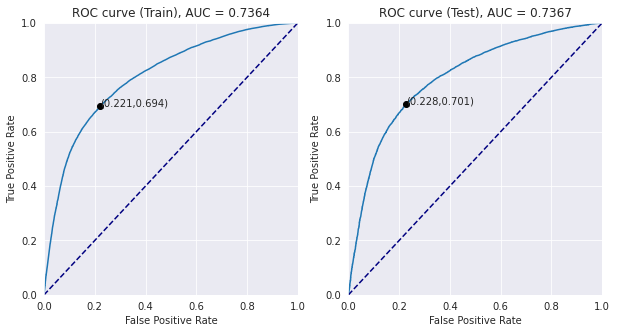

0.49218667

In [ ]:
plot_ROC(y_train, xgbc.predict_proba(X_train)[:,1], y_test, xgbc.predict_proba(X_test)[:,1])

In [ ]:
proba_test_preds = xgbc.predict_proba(X_test)
test_calibrated = np.apply_along_axis(lambda x: np.where(x[1] >= 0.4, 1, 0), axis=1, arr=proba_test_preds)
report(y_train, x_train_pred, y_test, test_calibrated)

Train
               precision    recall  f1-score   support

           0      0.719     0.784     0.750     24267
           1      0.757     0.687     0.720     23768

    accuracy                          0.736     48035
   macro avg      0.738     0.735     0.735     48035
weighted avg      0.738     0.736     0.735     48035

Test
               precision    recall  f1-score   support

           0      0.762     0.666     0.711     10400
           1      0.698     0.788     0.740     10187

    accuracy                          0.726     20587
   macro avg      0.730     0.727     0.725     20587
weighted avg      0.730     0.726     0.725     20587

Train ROC_AUC: 0.735, Test ROC_AUC: 0.727
Train logloss: 9.120, Test logloss: 9.461
Confusion Matrix 
 col_0      0     1
cardio            
0       6924  3476
1       2163  8024


In [ ]:
# # LGBM(flight for params) 
alpha = 0.95
learning_rate_min = 0.01
learning_rate_start = 0.1

lgbm = LGBMClassifier(boosting_type='goss', num_leaves=11, max_depth=6, learning_rate=0.3, n_estimators=800, class_weight=None,
                      subsample=1., n_jobs=-1, colsample_bytree=0.6, scale_pos_weight=1., random_state=1)  # change scale_pos_weight to force FP or FN
lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=5, eval_metric='accuracy',
         # callbacks=[lightgbm.reset_parameter(learning_rate=lambda current_round: max(learning_rate_min, learning_rate_start * np.power(alpha, current_round)))],
         )
l_train_pred = lgbm.predict(X_train)
l_test_pred = lgbm.predict(X_test)
report(y_train, l_train_pred, y_test, l_test_pred)

Train
               precision    recall  f1-score   support

           0      0.714     0.787     0.749     24267
           1      0.757     0.678     0.715     23768

    accuracy                          0.733     48035
   macro avg      0.736     0.733     0.732     48035
weighted avg      0.735     0.733     0.732     48035

Test
               precision    recall  f1-score   support

           0      0.718     0.779     0.747     10400
           1      0.753     0.687     0.719     10187

    accuracy                          0.734     20587
   macro avg      0.735     0.733     0.733     20587
weighted avg      0.735     0.734     0.733     20587

Train logloss: 9.219, Test logloss: 9.197
Confusion Matrix 
 col_0      0     1
cardio            
0       8104  2296
1       3186  7001


Меры правильности перекрекстной оценки: [0.73022481 0.73751041 0.72606162 0.72127394 0.72085762 0.71830106
 0.72204872 0.72787841 0.73870498 0.72308974]
Точность перекретсной оценки: 0.727 +/- 0.007




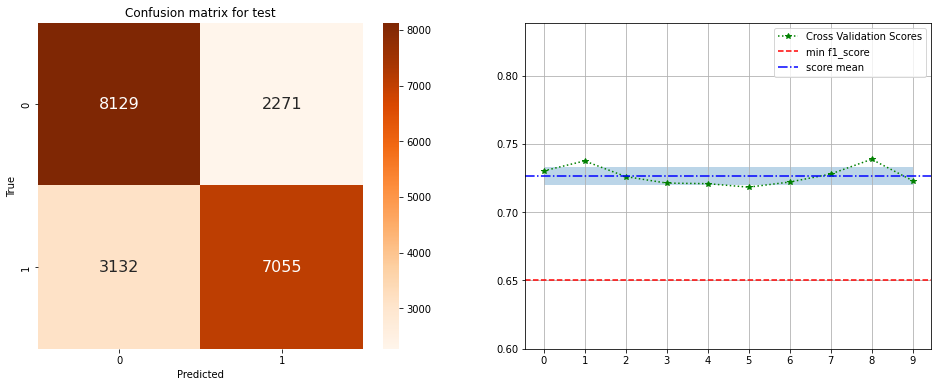

In [ ]:
plot_cm_val(y_test, l_test_pred, X_train, y_train, lgbm, scoring='accuracy') 

Train Accuracy: 0.736025814510253 
Train AUC: 0.7355764285526147 
Train Confusion Matrix:
[[18900  5367]
 [ 7313 16455]]
Test Accuracy: 0.7366299120804392 
Test AUC: 0.7362609396591433 
Test Confusion Matrix:
[[8028 2372]
 [3050 7137]]


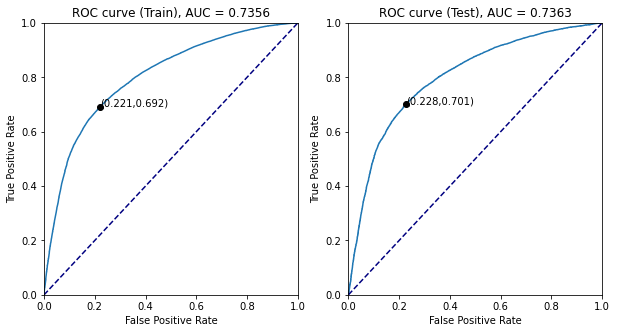

0.49083763347757603

In [ ]:
plot_ROC(y_train, lgbm.predict_proba(X_train)[:,1], y_test, lgbm.predict_proba(X_test)[:,1])

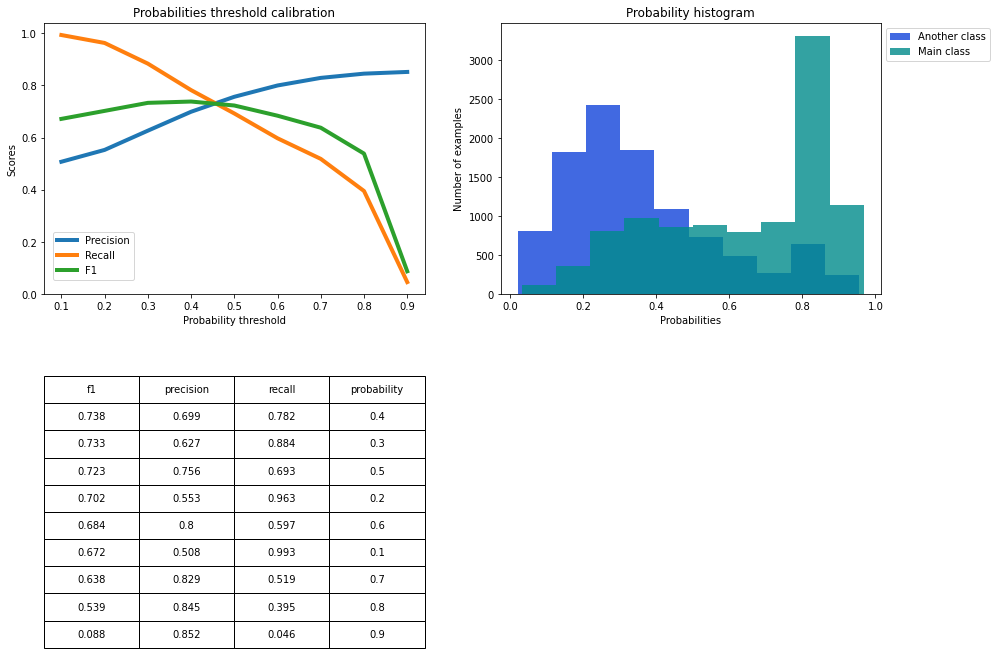

In [ ]:
show_proba_calibration_plots(lgbm.predict_proba(X_test)[:,1], y_test)

In [ ]:
proba_test_preds = lgbm.predict_proba(X_test)
test_calibrated = np.apply_along_axis(lambda x: np.where(x[1] >= 0.4, 1, 0), axis=1, arr=proba_test_preds)
report(y_train, l_train_pred, y_test, test_calibrated)

Train
               precision    recall  f1-score   support

           0      0.717     0.787     0.750     24267
           1      0.758     0.683     0.719     23768

    accuracy                          0.736     48035
   macro avg      0.738     0.735     0.735     48035
weighted avg      0.738     0.736     0.735     48035

Test
               precision    recall  f1-score   support

           0      0.758     0.670     0.712     10400
           1      0.699     0.782     0.738     10187

    accuracy                          0.726     20587
   macro avg      0.729     0.726     0.725     20587
weighted avg      0.729     0.726     0.725     20587

Train ROC_AUC: 0.735, Test ROC_AUC: 0.726
Train logloss: 9.133, Test logloss: 9.477
Confusion Matrix 
 col_0      0     1
cardio            
0       6971  3429
1       2220  7967


In [ ]:
# CatBoost (weather for params), #Shap importancies Shap plots

$**CatBoost**$

In [ ]:
X_train, X_test, y_train, y_test = pipeline(data_root, cat=True)

Reading dataframe
Dropping duplicates
Dealing with outliers, converting features
Samples left: 68622
Optimizing memory usage
Memory usage of dataframe is 6.02 MB
Memory usage after optimization is: 2.29 MB
Decreased by 62.0%
Feature optimizing and generating
Getting optimal split for train/ test; feature encoding


In [ ]:
cat_cols = X_train.select_dtypes(include=np.int8).columns.to_list()

In [ ]:
# results from the box
"""
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols) 
catboost = CatBoostClassifier(verbose=False, random_state=1)
catboost.fit(train_pool, eval_set=test_pool)
cat_train_preds = catboost.predict(X_train)
cat_test_preds = catboost.predict(X_test)
report(y_train, cat_train_preds, y_test, cat_test_preds)
"""

Train
               precision    recall  f1-score   support

           0      0.723     0.785     0.753     24267
           1      0.760     0.692     0.724     23768

    accuracy                          0.739     48035
   macro avg      0.741     0.739     0.739     48035
weighted avg      0.741     0.739     0.739     48035

Test
               precision    recall  f1-score   support

           0      0.725     0.775     0.749     10400
           1      0.753     0.700     0.726     10187

    accuracy                          0.738     20587
   macro avg      0.739     0.738     0.737     20587
weighted avg      0.739     0.738     0.737     20587

Train ROC_AUC: 0.739, Test ROC_AUC: 0.738
Train logloss: 9.001, Test logloss: 9.053
Confusion Matrix 
 col_0      0     1
cardio            
0       8057  2343
1       3053  7134


In [ ]:
# feature selection by shap values
feature_names = list(X_train.columns)
cat_indices = [i for i, col in enumerate(X_train.columns) if col in cat_cols]

train_pool = Pool(X_train, y_train, feature_names=feature_names, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, feature_names=feature_names, cat_features=cat_cols)

def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=200, random_seed=0)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=11,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False,
        logging_level='Silent',
        plot=False
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues
Selected features: ['age', 'gender', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'ap_ratio']


In [ ]:
# taking selected features
X_train_s = X_train[['age', 'gender', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'ap_ratio']]
X_test_s = X_test[['age', 'gender', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'ap_ratio']]
cat_cols_s = X_train.select_dtypes(include=np.int8).columns.to_list()
train_pool = Pool(X_train_s, y_train, cat_features=cat_cols_s)
test_pool = Pool(X_test_s, y_test, cat_features=cat_cols_s) 

In [ ]:
# results from the box, using selected features
catboost = CatBoostClassifier(verbose=False, random_state=1)
catboost.fit(train_pool, eval_set=test_pool)
cat_train_preds = catboost.predict(X_train_s)
cat_test_preds = catboost.predict(X_test_s)
report(y_train, cat_train_preds, y_test, cat_test_preds)

Train
               precision    recall  f1-score   support

           0      0.721     0.785     0.752     24267
           1      0.759     0.689     0.722     23768

    accuracy                          0.738     48035
   macro avg      0.740     0.737     0.737     48035
weighted avg      0.739     0.738     0.737     48035

Test
               precision    recall  f1-score   support

           0      0.724     0.777     0.749     10400
           1      0.754     0.697     0.724     10187

    accuracy                          0.738     20587
   macro avg      0.739     0.737     0.737     20587
weighted avg      0.739     0.738     0.737     20587

Train logloss: 9.058, Test logloss: 9.066
Confusion Matrix 
 col_0      0     1
cardio            
0       8080  2320
1       3084  7103


In [ ]:
params_model = {
    'eval_metric': 'Accuracy', # AUC, F1, Logloss
    #'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 3,
    'early_stopping_rounds': 5,
    'boosting_type': 'Ordered', # Plain
    'grow_policy': 'SymmetricTree', # 'Depthwise',
    'allow_writing_files': False,
    'use_best_model': True,
    'random_seed': 1,
    'max_ctr_complexity': 6,
    'combinations_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], # to increase border between encoded categories
    'simple_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'],
    
}

In [ ]:
catboost = CatBoostClassifier(**params_model)

params_grid = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.3, 0.5],
    'iterations': [50, 200],
    'l2_leaf_reg': [None, 2, 2.5, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2],
    'subsample': [None, 0.3, 0.5, 0.7, 0.9],
    'colsample_bylevel': [1., 0.5, 0.3, 0.8]
}
gs = catboost.randomized_search(params_grid, train_pool, n_iter=30, shuffle=True, stratified=True,
                                 partition_random_seed=1, cv=5)

In [ ]:
gs['params']

{'bagging_temperature': 1.5,
 'depth': 4,
 'iterations': 50,
 'l2_leaf_reg': 2.5,
 'learning_rate': 0.5,
 'rsm': 1.0,
 'subsample': 0.9}

In [ ]:
feature_weights = ','.join([f'{col}:2' if col in ['ap_hi', 'ap_lo'] else f'{col}:1' for col in X_train.columns.to_list()])
feature_weights

'age:1,gender:1,height:1,weight:1,ap_hi:2,ap_lo:2,cholesterol:1,gluc:1,smoke:1,alco:1,active:1,ap_ratio:1,mortality:1,target_cnt:1'

$*OPTUNA*$

In [ ]:
def objective(trial):
    param = {
                 'eval_metric': 'Accuracy',
                 'auto_class_weights': 'Balanced', # 'SqrtBalanced'
                 'silent': True,
                 'one_hot_max_size': 3,
                 'early_stopping_rounds': 15,
                 'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
                 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
                 'max_leaves': trial.suggest_int('max_leaves', 20, 40),
                 'allow_writing_files': False,
                 'use_best_model': True,
                 'sampling_frequency': 'PerTreeLevel',  # 'PerTree'
                 'random_seed': 1,
                 'depth': trial.suggest_int('depth', 4, 9),
                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                 'iterations': 800,
                 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.5),
                 'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.5),
                 'subsample': trial.suggest_float('subsample', 0.3, 1.),
                 'colsample_bylevel': trial.suggest_float('colsampe_bylevel', 0.3, 1.),
    }
    if param['grow_policy'] == 'SymmetricTree' or param['grow_policy'] == 'Depthwise':
        param['max_leaves'] = None
    if param['grow_policy'] == 'SymmetricTree':
        param['min_data_in_leaf'] = None
    if param['grow_policy'] != 'SymmetricTree':
        param['boosting_type'] = 'Plain'
    if param['grow_policy'] == 'Lossguide':
        param['sampling_frequency'] = 'PerTree'

    catboost = CatBoostClassifier(**param)
    catboost.fit(train_pool, eval_set=test_pool)
    
    y_pred = catboost.predict(X_test_s)
    score = accuracy_score(y_test, y_pred)
    
    return score

In [ ]:
study = optuna.create_study(sampler=TPESampler(), direction='maximize')
study.optimize(objective, n_trials=2000, timeout=7200)
print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2022-01-29 11:46:40,935] A new study created in memory with name: no-name-b929bf51-e1e1-4187-8d98-31fae3ce7be1
[I 2022-01-29 11:46:42,848] Trial 0 finished with value: 0.7389614805459757 and parameters: {'boosting_type': 'Ordered', 'grow_policy': 'Lossguide', 'min_data_in_leaf': 7, 'max_leaves': 20, 'depth': 5, 'learning_rate': 0.2451993837274441, 'l2_leaf_reg': 4.270405644108584, 'bagging_temperature': 3.0332436085173384, 'subsample': 0.8913592587061121, 'colsampe_bylevel': 0.7337254283182191}. Best is trial 0 with value: 0.7389614805459757.
[I 2022-01-29 11:46:44,111] Trial 1 finished with value: 0.7374556759119832 and parameters: {'boosting_type': 'Ordered', 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_leaves': 26, 'depth': 8, 'learning_rate': 0.19855858033757456, 'l2_leaf_reg': 4.969305895980932, 'bagging_temperature': 3.1647604340274147, 'subsample': 0.3986187755881577, 'colsampe_bylevel': 0.9089585350233615}. Best is trial 0 with value: 0.7389614805459757.
[I 2022-0

In [ ]:
params = {
     'boosting_type': 'Ordered', 
     'grow_policy': 'SymmetricTree', 
     'min_data_in_leaf': 7, 
     #'max_leaves': 23, 
     'depth': 7, 
     'learning_rate': 0.1820757910818346, 
     'l2_leaf_reg': 4.517979366955867, 
     'bagging_temperature': 2.3393099012884475, 
     'subsample': 0.9153927108423859, 
     'colsample_bylevel': 0.8226716472066944,
     'iterations': 800,
     'eval_metric': 'Accuracy',
     'auto_class_weights': 'Balanced', 
     'silent': True,
     'one_hot_max_size': 3,
     'early_stopping_rounds': 15,
     'allow_writing_files': False,
     'use_best_model': True,
     'sampling_frequency': 'PerTreeLevel',  
     'random_seed': 1,
     #'feature_weights': None     
}

In [ ]:
catboost = CatBoostClassifier(**params)
catboost.fit(train_pool, eval_set=test_pool)
cat_train_preds = catboost.predict(X_train_s)
cat_test_preds = catboost.predict(X_test_s)
cat_train_proba = catboost.predict_proba(X_train_s)[:,1]
cat_test_proba = catboost.predict_proba(X_test_s)[:,1]
report(y_train, cat_train_preds, y_test, cat_test_preds, cat_train_proba, cat_test_proba)

Train
               precision    recall  f1-score   support

           0      0.722     0.776     0.748     24267
           1      0.753     0.695     0.723     23768

    accuracy                          0.736     48035
   macro avg      0.737     0.736     0.736     48035
weighted avg      0.737     0.736     0.736     48035

Test
               precision    recall  f1-score   support

           0      0.730     0.772     0.750     10400
           1      0.752     0.709     0.730     10187

    accuracy                          0.740     20587
   macro avg      0.741     0.740     0.740     20587
weighted avg      0.741     0.740     0.740     20587

Train ROC_AUC: 0.807, Test ROC_AUC: 0.803
Train logloss: 9.112, Test logloss: 8.964
Confusion Matrix 
 col_0      0     1
cardio            
0       8024  2376
1       2967  7220


In [ ]:
# partial fit on test set
catboost_next = CatBoostClassifier(random_state=1, verbose=False)
catboost_next.fit(test_pool, init_model=catboost)
next_cat_test_preds = catboost_next.predict(X_test_s)
report(y_train, cat_train_preds, y_test, next_cat_test_preds)
# after partial fit from black box we got accuracy=0.763 - best for that notebook

Train
               precision    recall  f1-score   support

           0      0.720     0.774     0.746     24267
           1      0.750     0.692     0.720     23768

    accuracy                          0.734     48035
   macro avg      0.735     0.733     0.733     48035
weighted avg      0.735     0.734     0.733     48035

Test
               precision    recall  f1-score   support

           0      0.747     0.803     0.774     10400
           1      0.782     0.722     0.751     10187

    accuracy                          0.763     20587
   macro avg      0.764     0.762     0.762     20587
weighted avg      0.764     0.763     0.762     20587

Train ROC_AUC: 0.733, Test ROC_AUC: 0.762
Train logloss: 9.201, Test logloss: 8.197
Confusion Matrix 
 col_0      0     1
cardio            
0       8349  2051
1       2835  7352


In [ ]:
voted_labels_train = vote([x_train_pred, l_train_pred, cat_train_preds, vote_train_pred], weights=[1., 1.1, 1.3, 0.9])
voted_labels_test = vote([x_test_pred, l_test_pred, cat_test_preds, vote_test_pred], weights=[1., 1.1, 1.3, 0.9])
voted_labels_test_part = vote([x_test_pred, l_test_pred, next_cat_test_preds, vote_test_pred], weights=[1., 1.1, 1.5, 0.9])

In [ ]:
report(y_train, vote_train_pred, y_test, voted_labels_test)
print('='*40)
report(y_train, vote_train_pred, y_test, voted_labels_test_part)

Train
               precision    recall  f1-score   support

           0      0.707     0.804     0.752     24267
           1      0.767     0.660     0.710     23768

    accuracy                          0.733     48035
   macro avg      0.737     0.732     0.731     48035
weighted avg      0.737     0.733     0.731     48035

Test
               precision    recall  f1-score   support

           0      0.725     0.780     0.752     10400
           1      0.757     0.698     0.726     10187

    accuracy                          0.740     20587
   macro avg      0.741     0.739     0.739     20587
weighted avg      0.741     0.740     0.739     20587

Train ROC_AUC: 0.732, Test ROC_AUC: 0.739
Train logloss: 9.230, Test logloss: 8.994
Confusion Matrix 
 col_0      0     1
cardio            
0       8112  2288
1       3073  7114
Train
               precision    recall  f1-score   support

           0      0.707     0.804     0.752     24267
           1      0.767     0.660     

In [ ]:
# for usual implementation see flight_satisfaction.ipynb, get shap values by Explainer
# explainer = shap.TreeExplainer(lgbm)
# shap_values = explainer.shap_values(X_train)

In [ ]:
shap.initjs()
shap_values = catboost.get_feature_importance(train_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[0,:], X_train_s.iloc[0,:])
# fully explainable result: age > 50 is risky, but ap_hi = 120, ap_lo = 80 - ideal blood pressure,
# plus patient is active, ap_ratio is good

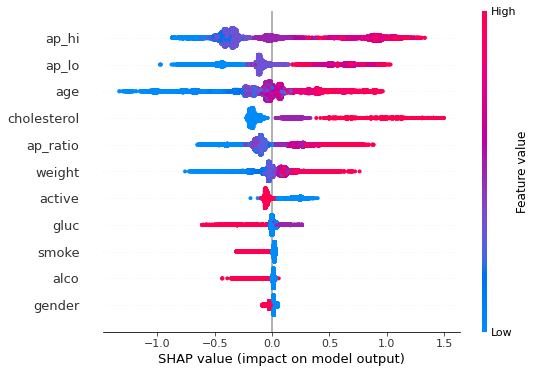

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_train_s)
# fully explainable results
# feature importancies: risky - ap_hi, ap_lo, age, high cholesterol level
# higher blood pressure, cholesterol occurs in CVD
# but surprisingly higher level of smoke and alco shows no CVD

In [ ]:
""" # quick way to explain prediction
import shap

data_for_prediction = val_X.iloc[0,:] 

explainer = shap.TreeExplainer(my_model)

def patient_risk_factors(row):
    shap_values = explainer.shap_values(row)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], row)
"""

In [ ]:
# as experimantal we will use catboost to train 4 separate models, dividing by age
# also as option we can use clustering

In [ ]:
X_train_s = X_train[['age', 'gender', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'ap_ratio']]
X_test_s = X_test[['age', 'gender', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'ap_ratio']]
cat_cols_s = X_train.select_dtypes(include=np.int8).columns.to_list()

In [ ]:
X_train_s[TARGET_NAME] = y_train.values
X_test_s[TARGET_NAME] = y_test.values

In [ ]:
q25, q50, q75 = np.quantile(X_train_s.age, q=0.25), np.quantile(X_train_s.age, q=0.5), np.quantile(X_train_s.age, q=0.75)

In [ ]:
X_train_q1 = X_train_s[X_train_s.age <= q25]
X_train_q2 = X_train_s[X_train_s.age.between(q25, q50, inclusive='right')]
X_train_q3 = X_train_s[X_train_s.age.between(q50, q75, inclusive='right')]
X_train_q4 = X_train_s[X_train_s.age > q75]

In [ ]:
for x in [X_train_q1, X_train_q2, X_train_q3, X_train_q4]:
    print(f'Number of samples: {x.shape[0]}')

Number of samples: 12010
Number of samples: 12021
Number of samples: 12014
Number of samples: 12009


In [ ]:
X_test_q1 = X_test_s[X_test_s.age <= q25]
X_test_q2 = X_test_s[X_test_s.age.between(q25, q50, inclusive='right')]
X_test_q3 = X_test_s[X_test_s.age.between(q50, q75, inclusive='right')]
X_test_q4 = X_test_s[X_test_s.age > q75]

In [ ]:
for x in [X_test_q1, X_test_q2, X_test_q3, X_test_q4]:
    print(f'Number of samples: {x.shape[0]}')

Number of samples: 5036
Number of samples: 5149
Number of samples: 5202
Number of samples: 5210


In [ ]:
X_train_q1, y_train_q1 = X_train_q1.drop(TARGET_NAME, axis=1), X_train_q1[TARGET_NAME]
X_train_q2, y_train_q2 = X_train_q2.drop(TARGET_NAME, axis=1), X_train_q2[TARGET_NAME]
X_train_q3, y_train_q3 = X_train_q3.drop(TARGET_NAME, axis=1), X_train_q3[TARGET_NAME]
X_train_q4, y_train_q4 = X_train_q4.drop(TARGET_NAME, axis=1), X_train_q4[TARGET_NAME]

X_test_q1, y_test_q1 = X_test_q1.drop(TARGET_NAME, axis=1), X_test_q1[TARGET_NAME]
X_test_q2, y_test_q2 = X_test_q2.drop(TARGET_NAME, axis=1), X_test_q2[TARGET_NAME]
X_test_q3, y_test_q3 = X_test_q3.drop(TARGET_NAME, axis=1), X_test_q3[TARGET_NAME]
X_test_q4, y_test_q4 = X_test_q4.drop(TARGET_NAME, axis=1), X_test_q4[TARGET_NAME]

In [ ]:
train_dict, test_dict = {}, {}
train_dict['set1'] = (X_train_q1, y_train_q1)
train_dict['set2'] = (X_train_q2, y_train_q2)
train_dict['set3'] = (X_train_q3, y_train_q3)
train_dict['set4'] = (X_train_q4, y_train_q4)

test_dict['set1'] = (X_test_q1, y_test_q1)
test_dict['set2'] = (X_test_q2, y_test_q2)
test_dict['set3'] = (X_test_q3, y_test_q3)
test_dict['set4'] = (X_test_q4, y_test_q4)

train_results, test_results = np.array([]), np.array([])

for i in range(1,5):
    train, train_target = train_dict.get(f'set{i}')
    test, test_target = test_dict.get(f'set{i}')
    train_pool = Pool(train, train_target, cat_features=cat_cols_s)
    test_pool = Pool(test, test_target, cat_features=cat_cols_s)
    cat = CatBoostClassifier(random_state=1, verbose=False, auto_class_weights='Balanced')
    cat.fit(train_pool)
    train_preds = cat.predict(train)
    test_preds = cat.predict(test)
    train_results = np.append(train_results, train_preds)
    test_results = np.append(test_results, test_preds)
    report(train_target, train_preds, test_target, test_preds)
    print('='*40)

Train
               precision    recall  f1-score   support

           0      0.849     0.878     0.863      7843
           1      0.754     0.706     0.729      4167

    accuracy                          0.818     12010
   macro avg      0.801     0.792     0.796     12010
weighted avg      0.816     0.818     0.817     12010

Test
               precision    recall  f1-score   support

           0      0.829     0.850     0.839      3261
           1      0.711     0.678     0.694      1775

    accuracy                          0.789      5036
   macro avg      0.770     0.764     0.767      5036
weighted avg      0.787     0.789     0.788      5036

Train ROC_AUC: 0.792, Test ROC_AUC: 0.764
Train logloss: 6.287, Test logloss: 7.277
Confusion Matrix 
 col_0      0     1
cardio            
0       2772   489
1        572  1203
Train
               precision    recall  f1-score   support

           0      0.748     0.849     0.795      6585
           1      0.781     0.654     

In [ ]:
true_train_labels = pd.concat([y_train_q1, y_train_q2, y_train_q3, y_train_q4], axis=0)
true_test_labels = pd.concat([y_test_q1, y_test_q2, y_test_q3, y_test_q4], axis=0)

In [ ]:
report(true_train_labels, train_results, true_test_labels, test_results)
# results from the box not improving

Train
               precision    recall  f1-score   support

           0      0.718     0.837     0.773     24278
           1      0.800     0.664     0.726     23776

    accuracy                          0.752     48054
   macro avg      0.759     0.751     0.749     48054
weighted avg      0.759     0.752     0.750     48054

Test
               precision    recall  f1-score   support

           0      0.695     0.804     0.746     10407
           1      0.762     0.640     0.695     10190

    accuracy                          0.723     20597
   macro avg      0.728     0.722     0.720     20597
weighted avg      0.728     0.723     0.721     20597

Train ROC_AUC: 0.751, Test ROC_AUC: 0.722
Train logloss: 8.575, Test logloss: 9.577
Confusion Matrix 
 col_0    0.0   1.0
cardio            
0       8368  2039
1       3672  6518
